# **Model Comparison** (nested models)

---

Let's define our Baseline:

We will make a median-based baseline among AI-ML job titles and top20 countries (in frequency terms)

In [222]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

In [223]:
# The MedianBaselineModel class is defined here. This class represents a baseline model 
# that uses median values for predictions and follows the scikit-learn estimator interface.
class MedianBaselineModel(BaseEstimator, RegressorMixin):
    
    def fit(self, X, y):
        # Concatenating features and target variable and then calculating the median
        self.baseline_model = pd.concat([X, y], axis=1)
        self.baseline_model = self.baseline_model.groupby(baseline_features).median().reset_index()
        return self
    
    def predict(self, X):
        # Merging test data with the baseline model to get predictions
        predictions = X.merge(self.baseline_model, on=baseline_features, how='left')
        return predictions['Annual_salary'].fillna(predictions['Annual_salary'].median())

- Data Preprocessing

In [224]:
# Reading the training and testing datasets
train_df = pd.read_csv('../../output/clean_train_df.csv')
test_df = pd.read_csv('../../output/clean_test_df.csv')

# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
test_df.drop(538, inplace=True)

# Defining the features to be used in the baseline model
top20countries = ['Country_USA', 'Country_Germany', 'Country_UK & Northern Ireland', 'Country_Canada', 'Country_France', 'Country_India',
       'Country_Spain', 'Country_Brazil', 'Country_Poland', 'Country_Australia', 'Country_Netherlands', 'Country_Italy',
       'Country_Switzerland', 'Country_Israel', 'Country_Sweden', 'Country_Austria', 'Country_Russian Federation',
       'Country_Mexico', 'Country_Denmark', 'Country_Belgium']

AI_ML_devs = ['Data scientist or machine learning specialist',
 'Engineer, data',
 'Data or business analyst',
 'Scientist']

baseline_features = AI_ML_devs + top20countries

# Preparing the feature matrices and target vectors for training and testing sets
X_train = train_df[baseline_features]
y_train = train_df['Annual_salary']

X_test = test_df[baseline_features]
y_test = test_df['Annual_salary']


# Scaling the features using StandardScaler to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting the scaled numpy arrays back to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

- Metrics, fit, and evaluation:

In [225]:
# Defining a function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Creating a scorer function for RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Initializing and fitting the MedianBaselineModel
model = MedianBaselineModel()
model.fit(X_train_scaled, y_train)

# Performing K-Fold Cross-Validation to evaluate the model's performance
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Calculating RMSE using cross-validation
cv_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=kf, scoring=rmse_scorer)

# Displaying the RMSE results from cross-validation
print(f"RMSE scores: {-cv_scores}")
print(f"Mean RMSE: {np.mean(-cv_scores)}")

# Creating a scorer function for R2
r2_scorer = make_scorer(r2_score)
print()
# Calculating R2 scores using cross-validation
r2_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=kf, scoring=r2_scorer)

# Displaying the R2 results from cross-validation
print(f"R2 scores: {r2_scores}")
print(f"Mean R2: {np.mean(r2_scores)}")


mean_rmse_baseline = np.mean(-cv_scores)
mean_r2_baseline = np.mean(r2_scores)

RMSE scores: [36868.20678374 35827.67066936 36970.02715986 36691.14055687]
Mean RMSE: 36589.26129245572

R2 scores: [0.46726564 0.51326773 0.46877047 0.42367303]
Mean R2: 0.46824421902776864


In [226]:
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)

train_rmse = rmse(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")

Train RMSE: 35356.62109712542
Train R2: 0.5057466124675649


In [227]:
model.fit(X_train_scaled, y_train)

y_pred_test = model.predict(X_test_scaled)

test_rmse = rmse(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

Test RMSE: 32905.35322530049
Test R2: 0.5587370398342486


---

In [228]:
model_names = ["sqrt-XGB", "sqrt-XGB+1", "sqrt-XGB+2", "sqrt-XGB+3", "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6", "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"]
cv_metrics = ["mean_train_r2", "mean_test_r2", "mean_train_rmse", "mean_test_rmse"]

data = []

for model in model_names:
    filepath = f"../../output/{model}-cv-results.csv"
    cv_results = pd.read_csv(filepath)
    
    data.append({
        "model": model,
        "mean_train_r2": np.mean(cv_results['mean_train_r2']),
        "mean_test_r2": np.mean(cv_results['mean_test_r2']),
        "mean_train_rmse": np.mean(cv_results['mean_train_rmse']),
        "mean_test_rmse": np.mean(cv_results['mean_test_rmse'])
    })


cv_comparison_df = pd.DataFrame(data)

cv_comparison_df


,model,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,sqrt-XGB,0.695234,0.616635,27649.332001,31078.895114
1,sqrt-XGB+1,0.707370,0.628570,27076.006757,30590.416254
2,sqrt-XGB+2,0.710177,0.629735,26935.125367,30538.015065
3,sqrt-XGB+3,0.710555,0.629196,26916.248372,30559.116768
4,sqrt-XGB+4,0.733561,0.649759,25789.006306,29703.241880
5,sqrt-XGB+5,0.735005,0.649934,25715.686628,29700.647265
6,sqrt-XGB+6,0.736612,0.649827,25632.837340,29705.756969
7,sqrt-XGB+7,0.737694,0.647482,25571.503084,29806.894776
8,sqrt-XGB+8,0.739017,0.648277,25503.340812,29772.113502
9,sqrt-XGB+9,0.741460,0.648430,25369.298772,29765.723519


In [229]:
model_names = ["sqrt-XGB", "sqrt-XGB+1", "sqrt-XGB+2", "sqrt-XGB+3", "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6", "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"]
train_test_comparison_data = []

for model in model_names:
    # print(f"Processing: {model}")
    y_train_pred = np.loadtxt(f"../../output/{model}-train-predictions.csv", delimiter=",")
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    train_test_comparison_data.append({
        "model": model,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    })

train_test_comparison_df = pd.DataFrame(train_test_comparison_data)
train_test_comparison_df

,model,train_r2,test_r2,train_rmse,test_rmse
0,sqrt-XGB,0.677271,0.644070,28570.308513,29552.910107
1,sqrt-XGB+1,0.719971,0.666396,26613.242681,28611.022955
2,sqrt-XGB+2,0.691010,0.651711,27955.574397,29233.954960
3,sqrt-XGB+3,0.723672,0.661170,26436.749626,28834.271435
4,sqrt-XGB+4,0.713489,0.663195,26919.496215,28747.975859
5,sqrt-XGB+5,0.714881,0.662521,26854.004577,28776.699242
6,sqrt-XGB+6,0.714347,0.662239,26879.130121,28788.752258
7,sqrt-XGB+7,0.716031,0.660835,26799.796471,28848.522199
8,sqrt-XGB+8,0.751457,0.657258,25072.459475,29000.216111
9,sqrt-XGB+9,0.718950,0.656385,26661.702266,29037.151319


In [230]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

model_names = ["sqrt-XGB", "sqrt-XGB+1", "sqrt-XGB+2", "sqrt-XGB+3", "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6", "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"]
model_shapes = {
    "sqrt-XGB": (92, 92),
    "sqrt-XGB+1": (95, 95),
    "sqrt-XGB+2": (96, 96),
    "sqrt-XGB+3": (97, 97),
    "sqrt-XGB+4": (98, 98),
    "sqrt-XGB+5": (103, 103),
    "sqrt-XGB+6": (109, 109),
    "sqrt-XGB+7": (118, 118),
    "sqrt-XGB+8": (121, 121),
    "sqrt-XGB+9": (129, 129)
}

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Inicializar una lista para almacenar los datos
data = []

for model in model_names:
    y_train_pred = np.loadtxt(f"../../output/{model}-train-predictions.csv", delimiter=",")
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    n_train = len(y_train)
    n_test = len(y_test)
    p_train, p_test = model_shapes[model]
    
    adj_train_r2 = adjusted_r2(train_r2, n_train, p_train)
    adj_test_r2 = adjusted_r2(test_r2, n_test, p_test)
    
    data.append({
        "model": model,
        "train_r2": train_r2,
        "adjusted_train_r2": adj_train_r2,
        "test_r2": test_r2,
        "adjusted_test_r2": adj_test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    })

# Crear DataFrame a partir de la lista de datos
train_test_comparison_df = pd.DataFrame(data)
train_test_comparison_df = train_test_comparison_df.set_index('model')

# Mostrar las columnas seleccionadas
print(train_test_comparison_df[['train_r2', 'test_r2', 'train_rmse', 'test_rmse', 'adjusted_train_r2', 'adjusted_test_r2']].to_markdown())


| model      |   train_r2 |   test_r2 |   train_rmse |   test_rmse |   adjusted_train_r2 |   adjusted_test_r2 |
|:-----------|-----------:|----------:|-------------:|------------:|--------------------:|-------------------:|
| sqrt-XGB   |   0.677271 |  0.64407  |      28570.3 |     29552.9 |            0.663493 |           0.572729 |
| sqrt-XGB+1 |   0.719971 |  0.666396 |      26613.2 |     28611   |            0.707609 |           0.596895 |
| sqrt-XGB+2 |   0.69101  |  0.651711 |      27955.6 |     29234   |            0.677219 |           0.578226 |
| sqrt-XGB+3 |   0.723672 |  0.66117  |      26436.7 |     28834.3 |            0.711206 |           0.588776 |
| sqrt-XGB+4 |   0.713489 |  0.663195 |      26919.5 |     28748   |            0.700423 |           0.590332 |
| sqrt-XGB+5 |   0.714881 |  0.662521 |      26854   |     28776.7 |            0.701184 |           0.584931 |
| sqrt-XGB+6 |   0.714347 |  0.662239 |      26879.1 |     28788.8 |            0.699784 |           0.5

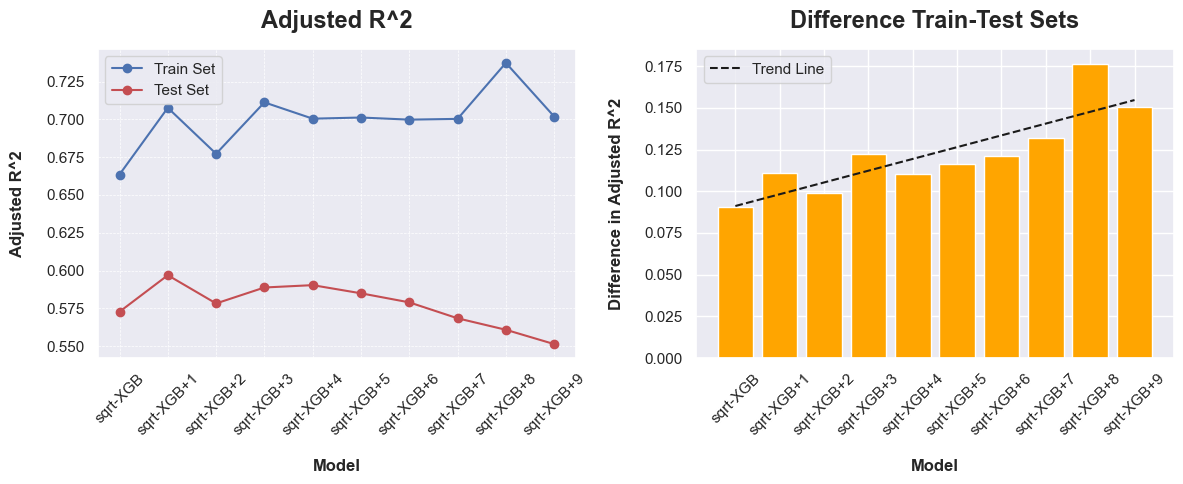

In [231]:
models = train_test_comparison_df.index.tolist()
adjusted_r2_values_tr = train_test_comparison_df['adjusted_train_r2'].tolist()
adjusted_r2_values_te = train_test_comparison_df['adjusted_test_r2'].tolist()

difference_adjusted_r2_values = np.array(adjusted_r2_values_tr) - np.array(adjusted_r2_values_te)

# Create subplots: one for the original R^2 values and one for the difference
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot with the original R^2 values
axs[0].plot(models, adjusted_r2_values_tr, marker='o', linestyle='-', color='b', label='Train Set')
axs[0].plot(models, adjusted_r2_values_te, marker='o', linestyle='-', color='r', label='Test Set')
axs[0].set_title('Adjusted R^2', fontsize=17,  weight='bold', pad=15)
axs[0].set_xlabel('Model', labelpad=15, weight='bold', fontsize=12)
axs[0].set_ylabel('Adjusted R^2', labelpad=15, weight='bold', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5)

# Second subplot with the difference in R^2 values
axs[1].bar(models, difference_adjusted_r2_values, color='orange')
axs[1].set_title('Difference Train-Test Sets', fontsize=17,  weight='bold', pad=15)
axs[1].set_xlabel('Model', labelpad=15, weight='bold', fontsize=12)
axs[1].set_ylabel('Difference in Adjusted R^2', labelpad=15, weight='bold', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
# axs[1].legend()

# Calculate and plot the trend line for the difference in R^2 values
z = np.polyfit(range(len(models)), difference_adjusted_r2_values, 1)
p = np.poly1d(z)
axs[1].plot(models, p(range(len(models))), "k--", label='Trend Line')
axs[1].legend()


plt.tight_layout()
plt.show()

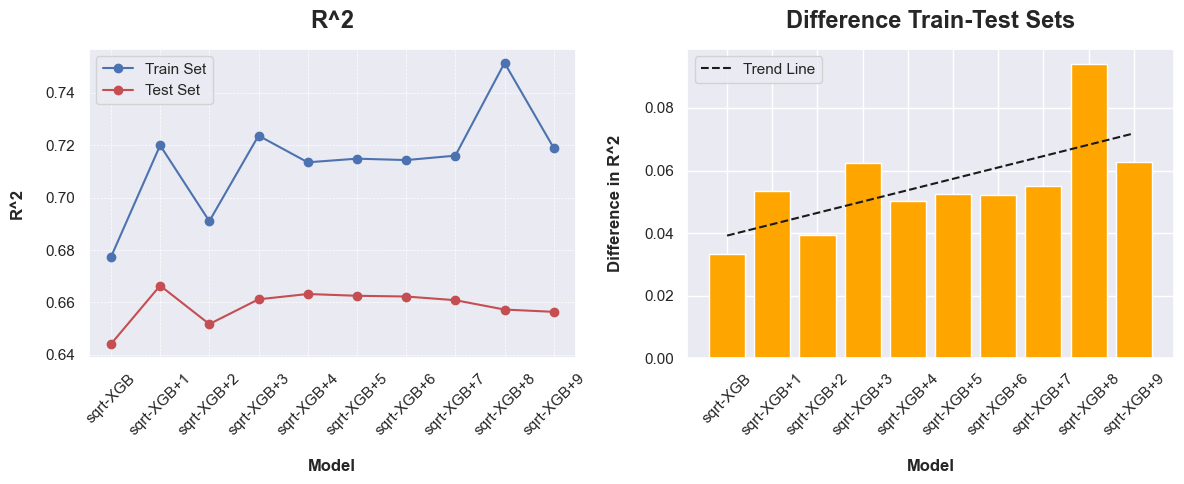

In [232]:
models = train_test_comparison_df.index.tolist()
r2_values_tr = train_test_comparison_df['train_r2'].tolist()
r2_values_te = train_test_comparison_df['test_r2'].tolist()

difference_r2_values = np.array(r2_values_tr) - np.array(r2_values_te)

# Create subplots: one for the original R^2 values and one for the difference
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot with the original R^2 values
axs[0].plot(models, r2_values_tr, marker='o', linestyle='-', color='b', label='Train Set')
axs[0].plot(models, r2_values_te, marker='o', linestyle='-', color='r', label='Test Set')
axs[0].set_title('R^2', fontsize=17,  weight='bold', pad=15)
axs[0].set_xlabel('Model', labelpad=15, weight='bold', fontsize=12)
axs[0].set_ylabel('R^2', labelpad=15, weight='bold', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5)

# Second subplot with the difference in R^2 values
axs[1].bar(models, difference_r2_values, color='orange')
axs[1].set_title('Difference Train-Test Sets', fontsize=17,  weight='bold', pad=15)
axs[1].set_xlabel('Model', labelpad=15, weight='bold', fontsize=12)
axs[1].set_ylabel('Difference in R^2', labelpad=15, weight='bold', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
# axs[1].legend()

# Calculate and plot the trend line for the difference in R^2 values
z = np.polyfit(range(len(models)), difference_r2_values, 1)
p = np.poly1d(z)
axs[1].plot(models, p(range(len(models))), "k--", label='Trend Line')
axs[1].legend()

plt.tight_layout()
plt.show()

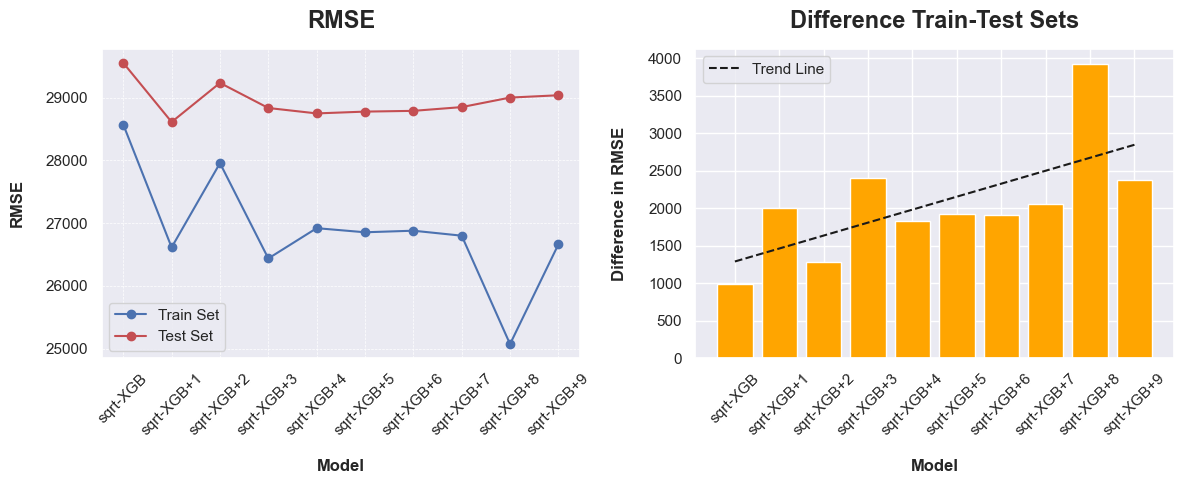

In [233]:
# Extracting model names and adjusted R^2 values
models = train_test_comparison_df.index.tolist()
rmse_values_tr = train_test_comparison_df['train_rmse'].tolist()
rmse_values_te = train_test_comparison_df['test_rmse'].tolist()

difference_rmse_values = np.abs(np.array(rmse_values_tr) - np.array(rmse_values_te))

# Create subplots: one for the original R^2 values and one for the difference
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot with the original R^2 values
axs[0].plot(models, rmse_values_tr, marker='o', linestyle='-', color='b', label='Train Set')
axs[0].plot(models, rmse_values_te, marker='o', linestyle='-', color='r', label='Test Set')
axs[0].set_title('RMSE', fontsize=17,  weight='bold', pad=15)
axs[0].set_xlabel('Model', labelpad=15, weight='bold', fontsize=12)
axs[0].set_ylabel('RMSE', labelpad=15, weight='bold', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5)

# Second subplot with the difference in R^2 values
axs[1].bar(models, difference_rmse_values, color='orange')
axs[1].set_title('Difference Train-Test Sets', fontsize=17,  weight='bold', pad=15)
axs[1].set_xlabel('Model', labelpad=15, weight='bold', fontsize=12)
axs[1].set_ylabel('Difference in RMSE', labelpad=15, weight='bold', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
# axs[1].legend()

# Calculate and plot the trend line for the difference in R^2 values
z = np.polyfit(range(len(models)), difference_rmse_values, 1)
p = np.poly1d(z)
axs[1].plot(models, p(range(len(models))), "k--", label='Trend Line')
axs[1].legend()


plt.tight_layout()
plt.show()

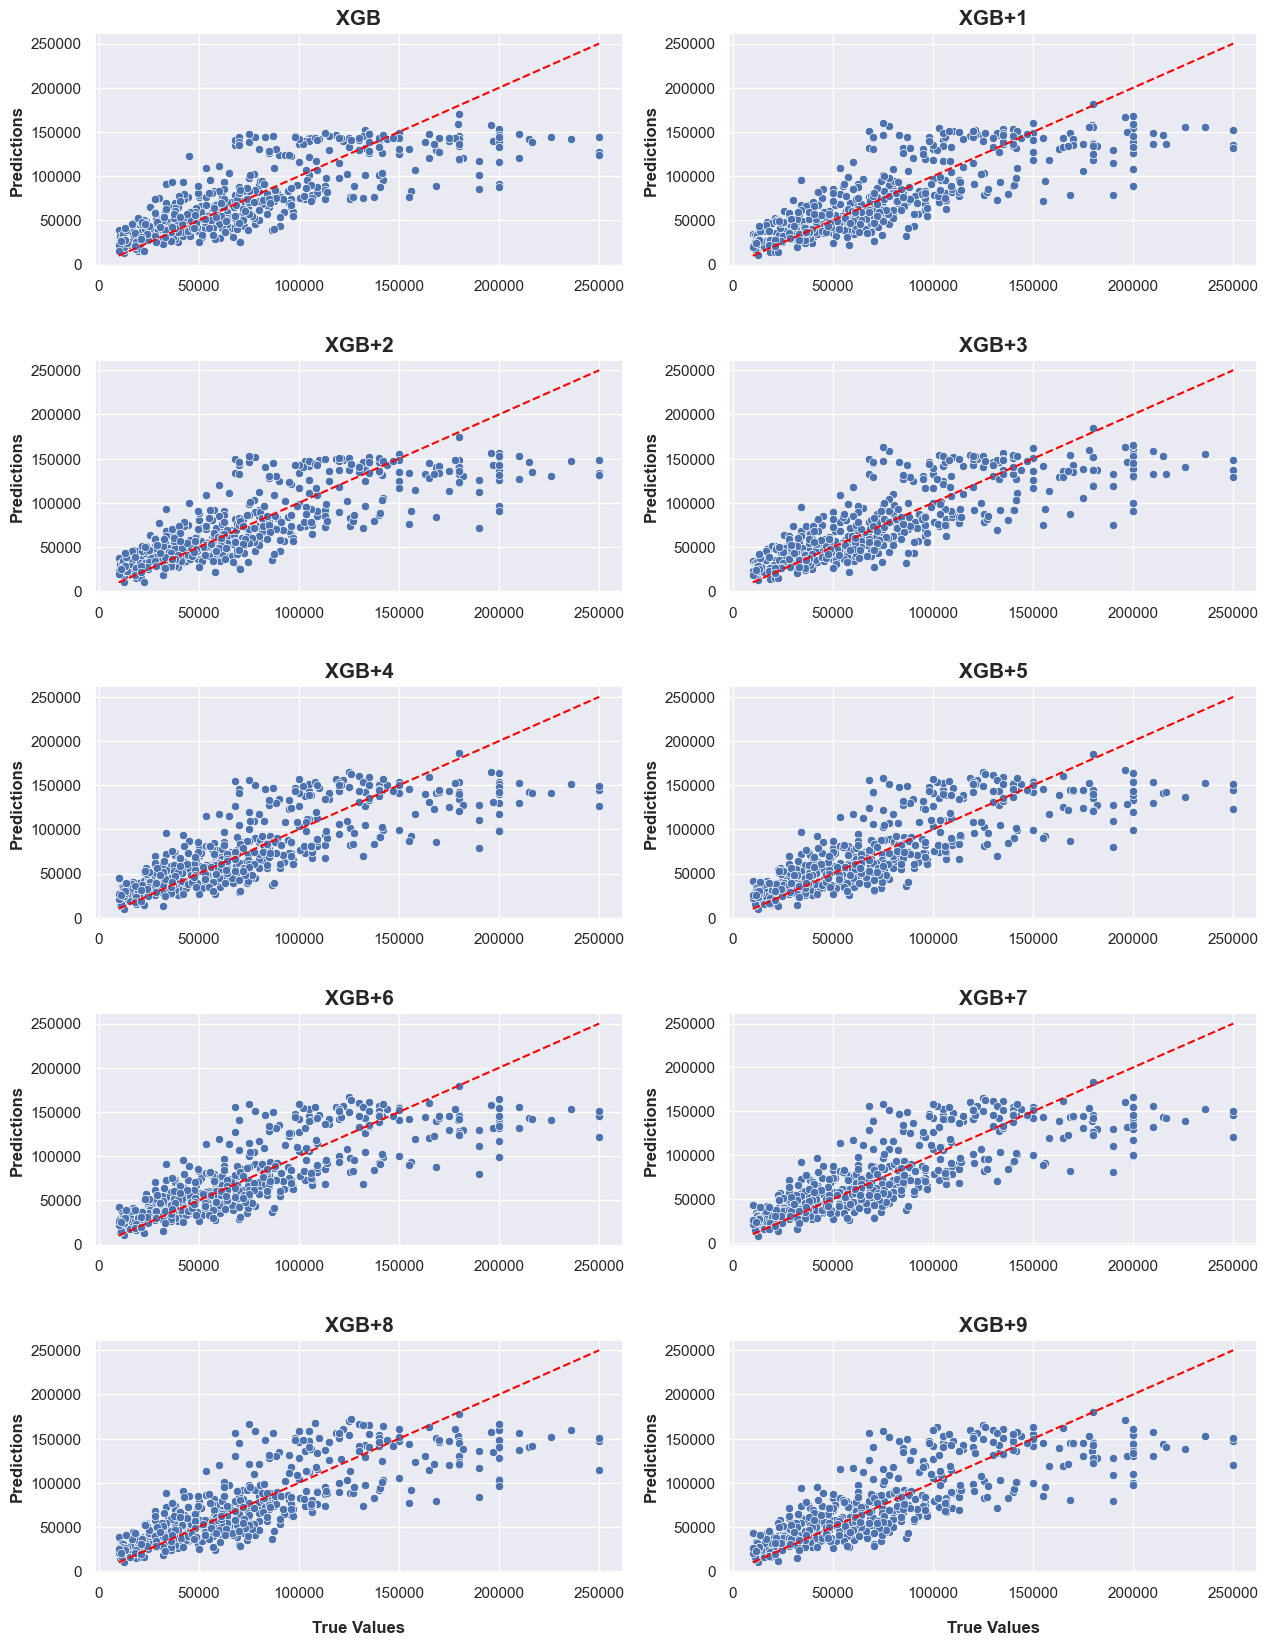

In [234]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.scatterplot(x=y_test, y=y_test_pred, ax=axs[i])
    axs[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    axs[i].set_title(f'{model}', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('True Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Predictions', weight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-performance.pdf")
plt.show()

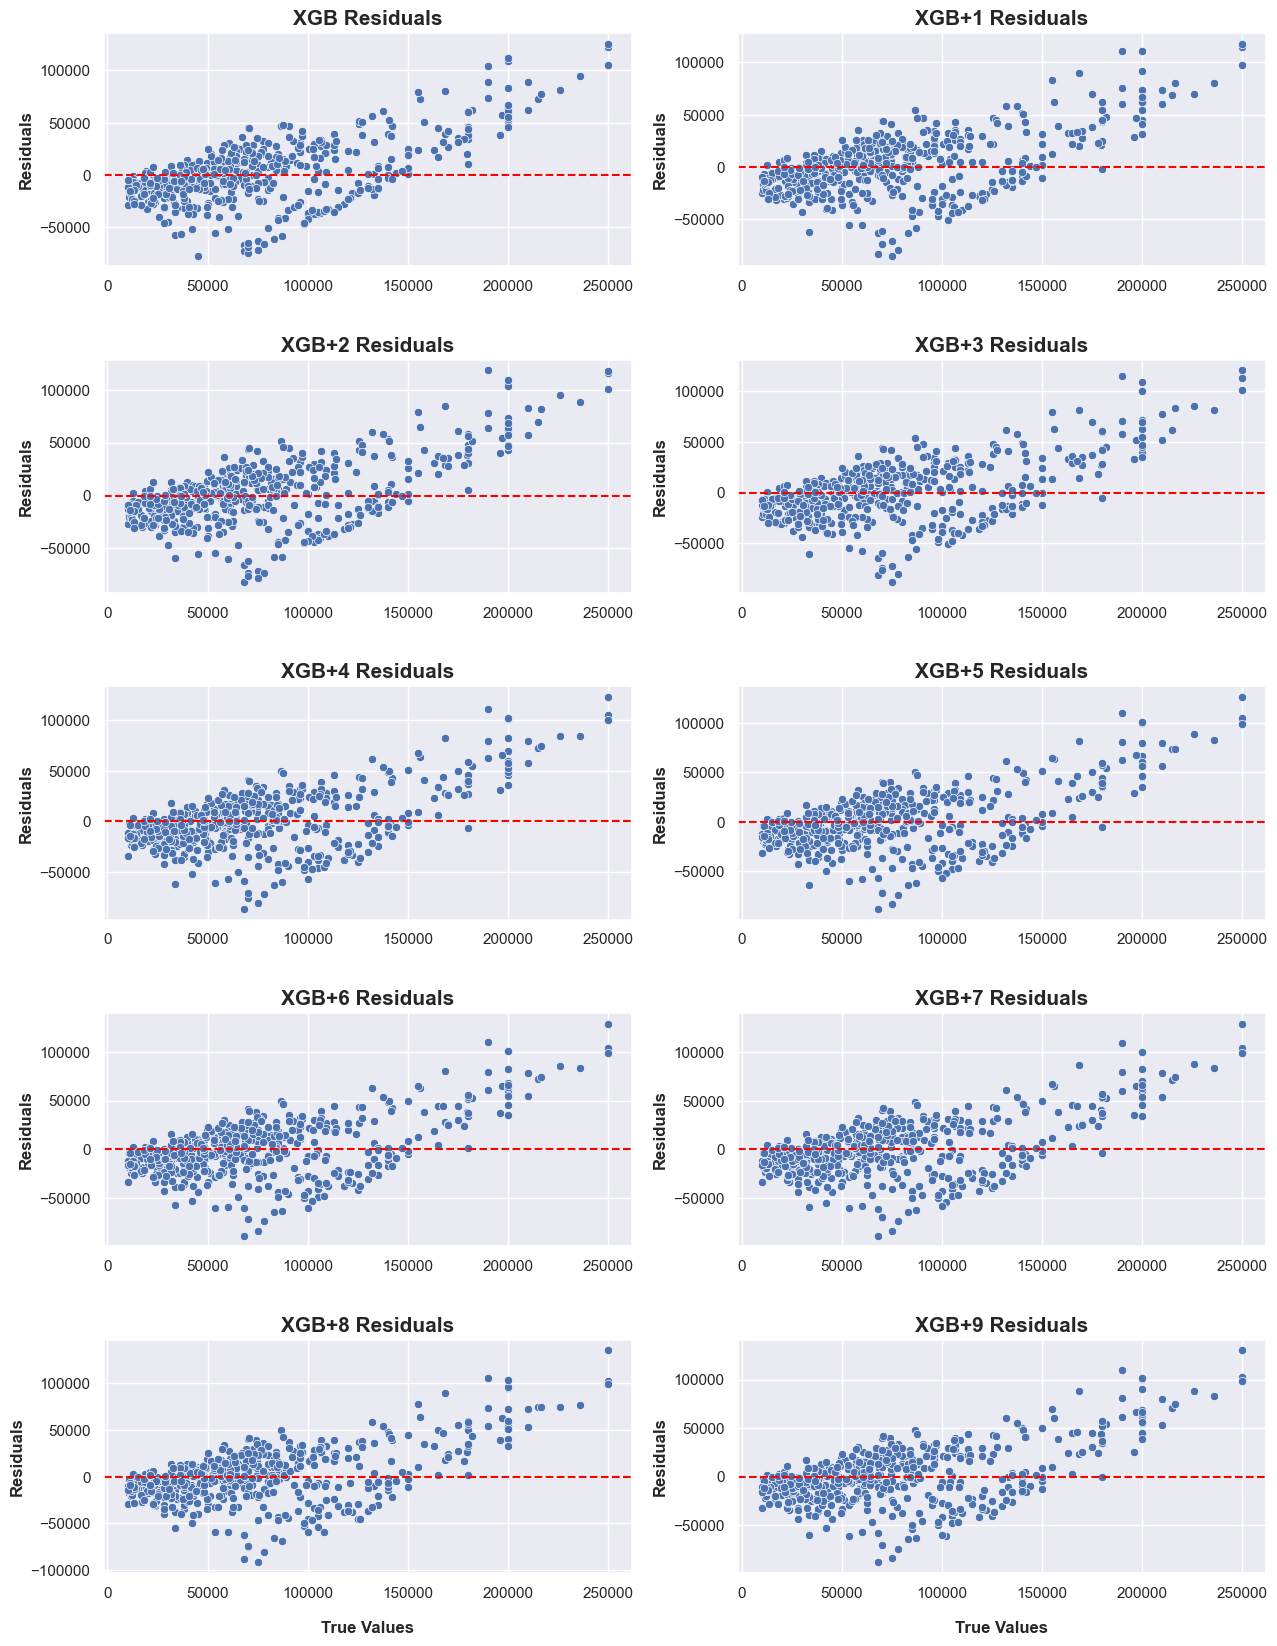

In [235]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    residuals = y_test - y_test_pred
    
    sns.scatterplot(x=y_test, y=residuals, ax=axs[i])
    axs[i].axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0 para los residuales
    axs[i].set_title(f'{model} Residuals', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('True Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Residuals', weight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-residuals.pdf")
plt.show()


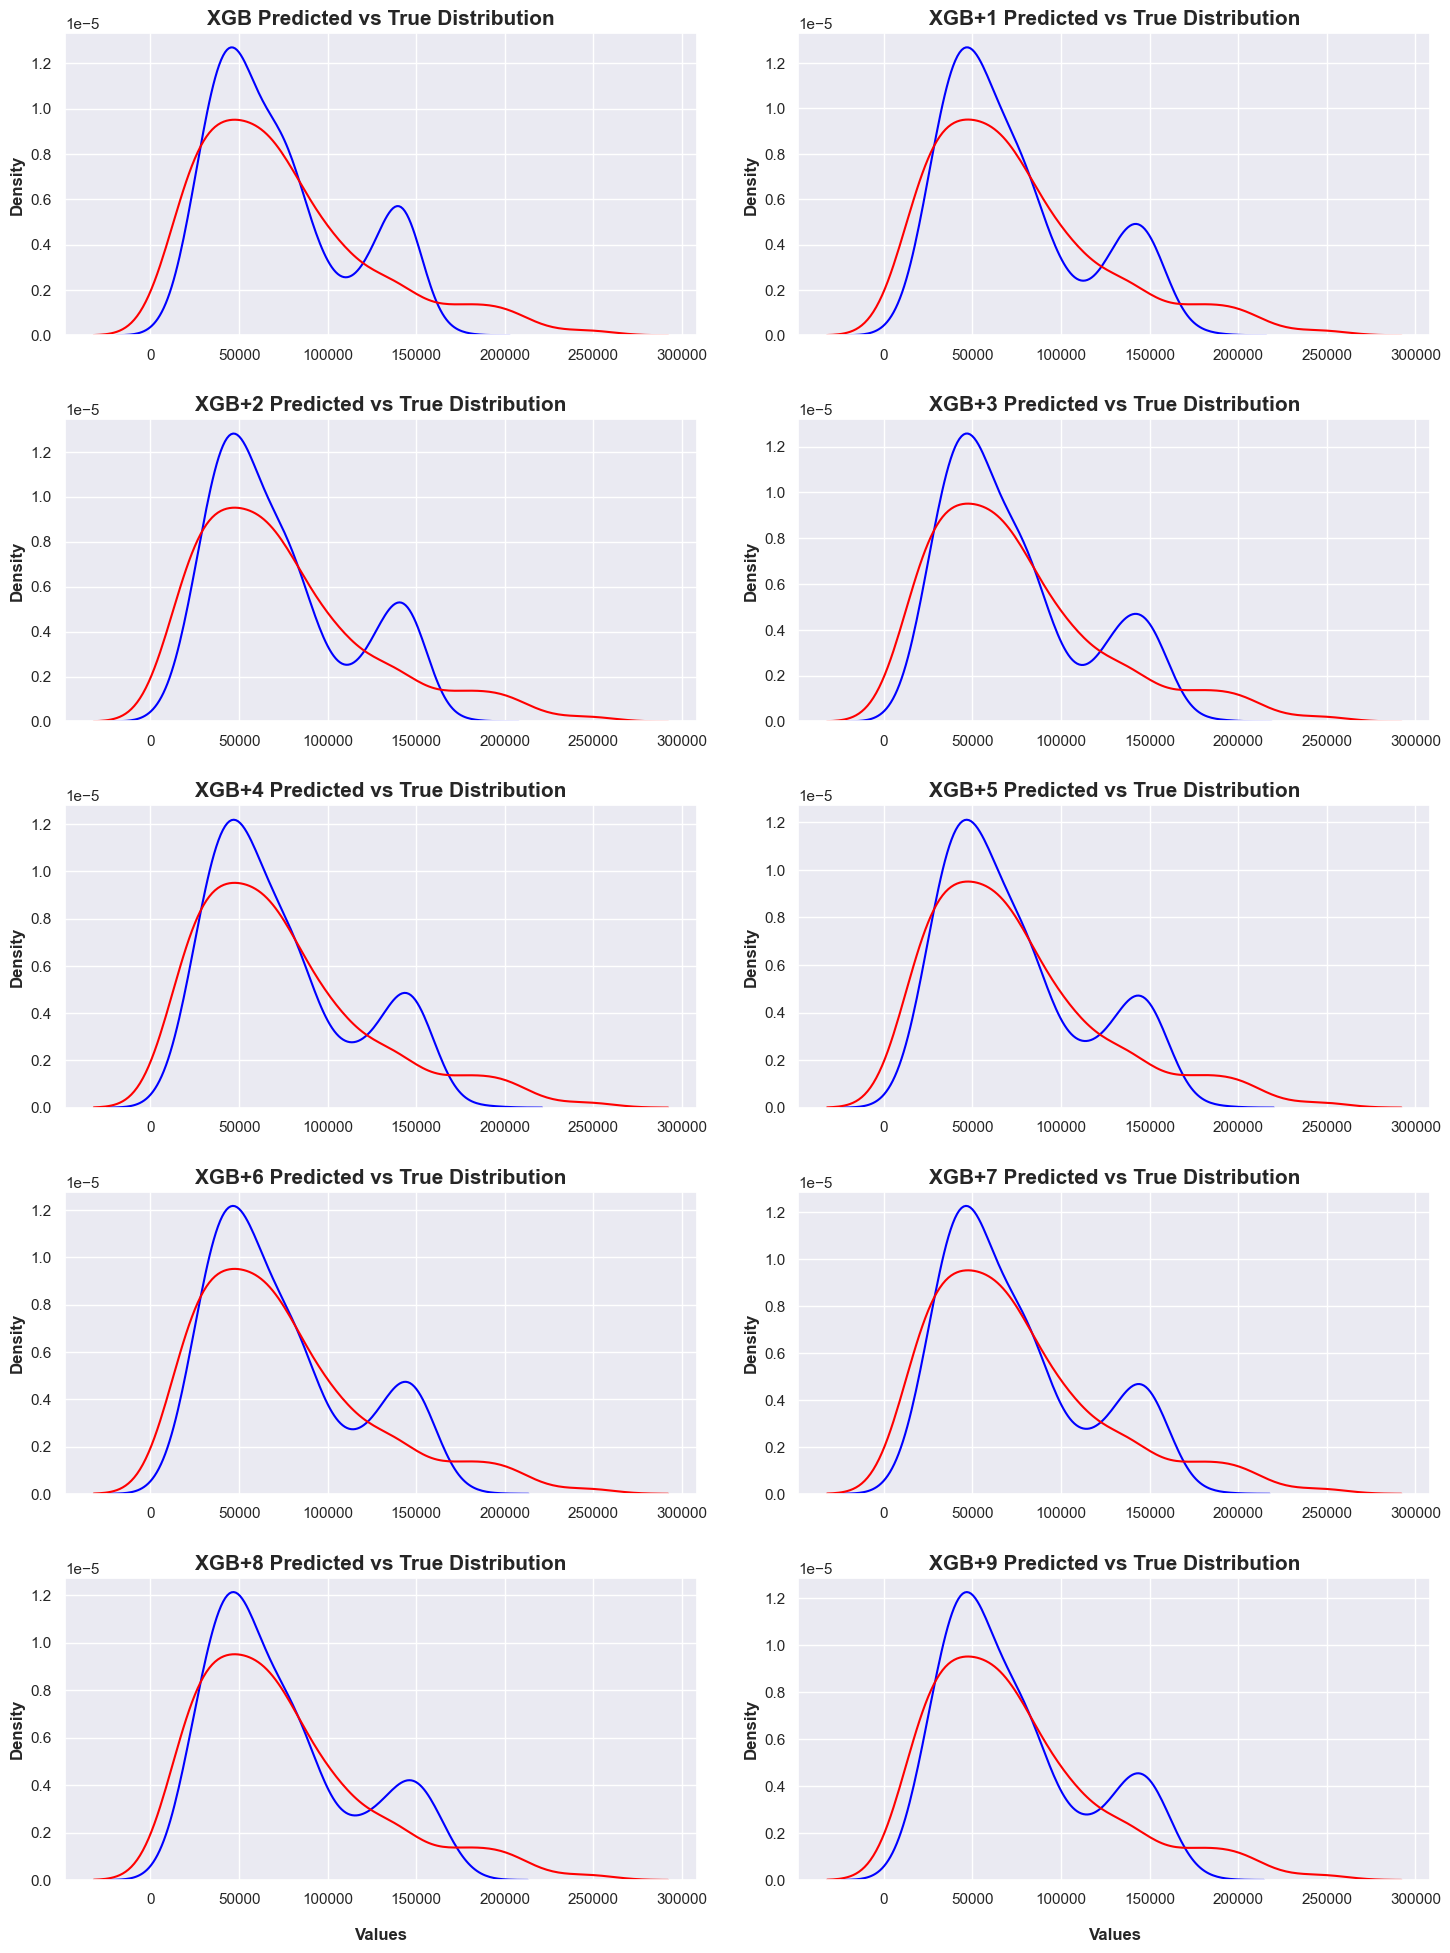

In [236]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test_pred, color='blue', label='Predicted Values', ax=axs[i])
    sns.kdeplot(x=y_test, color='red', label='True Values', ax=axs[i])
    axs[i].set_title(f'{model} Predicted vs True Distribution', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Density', weight='bold', fontsize=12)

plt.tight_layout(pad=2.0)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

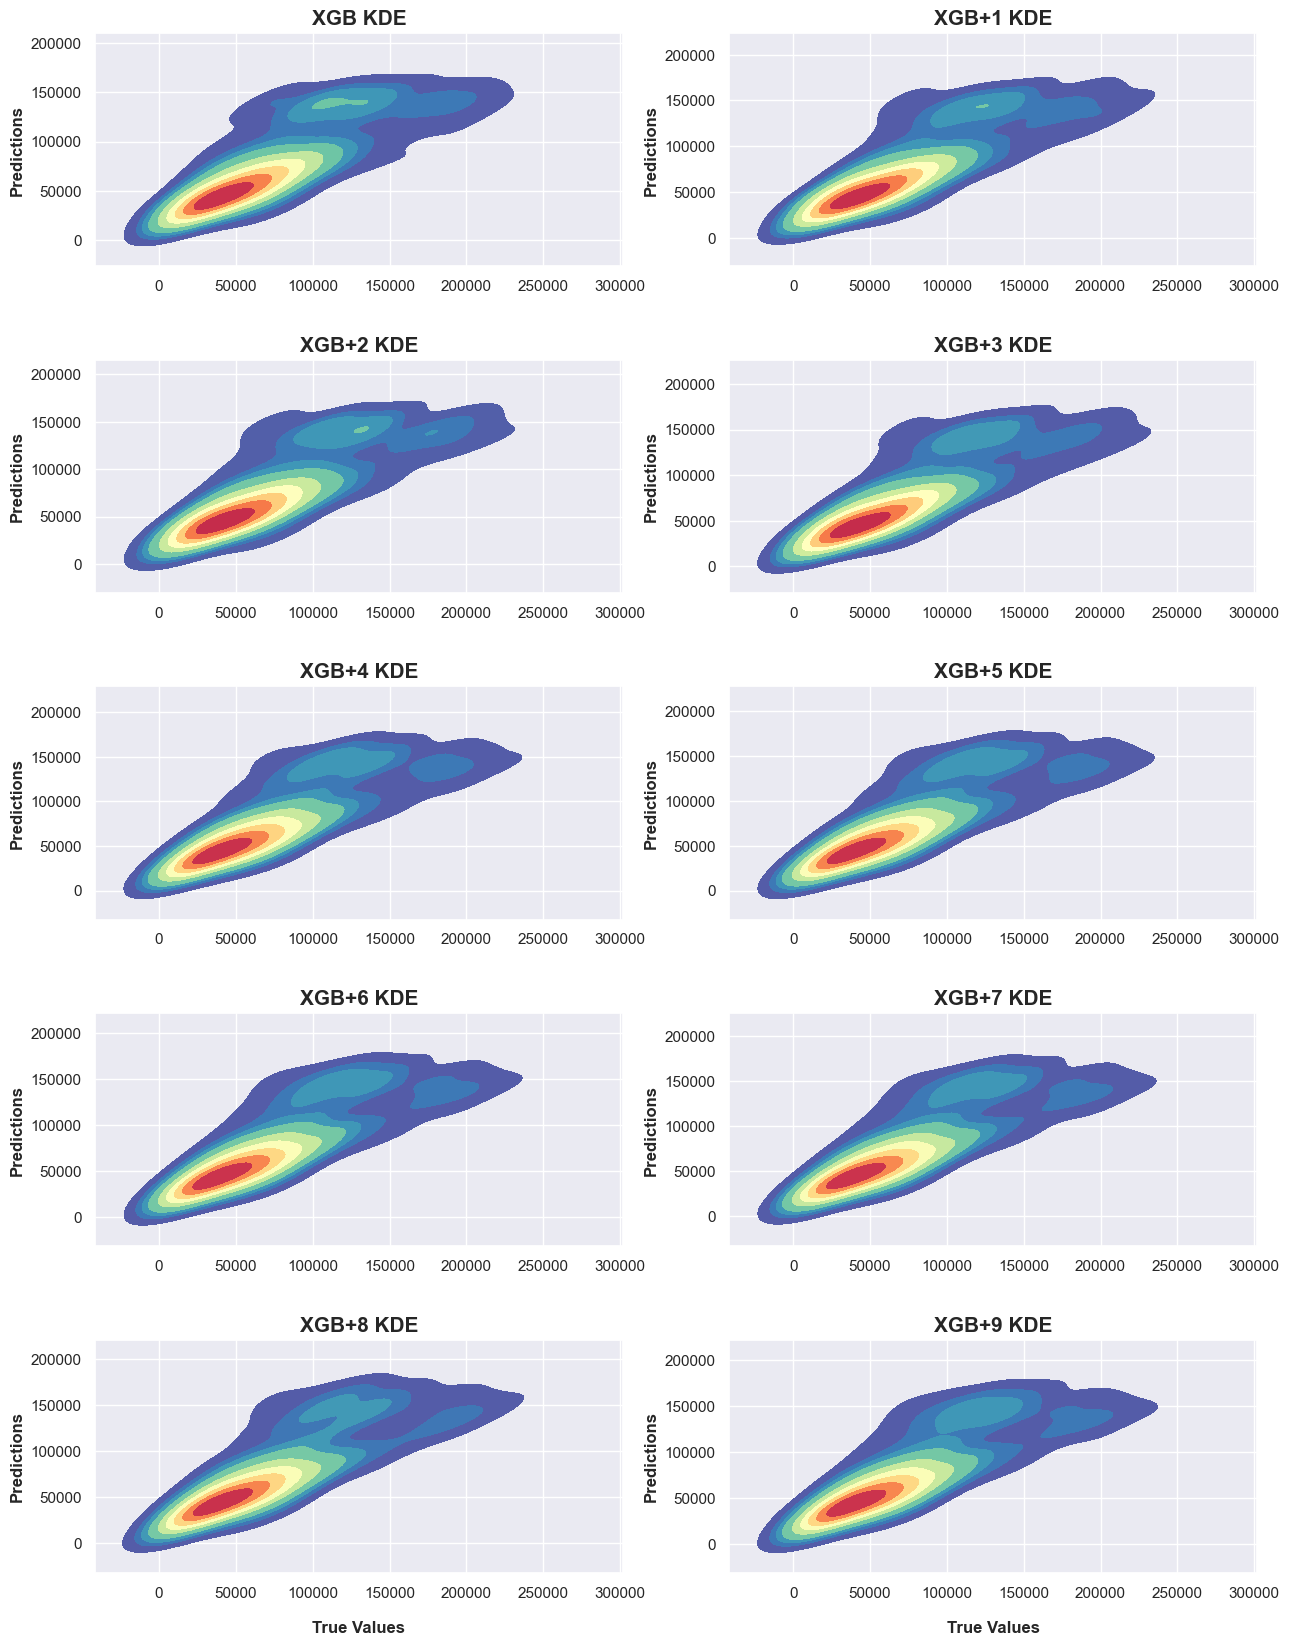

In [237]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test, y=y_test_pred, fill=True, ax=axs[i], cmap="Spectral_r")
    
    axs[i].set_title(f'{model} KDE', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('True Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Predictions', weight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

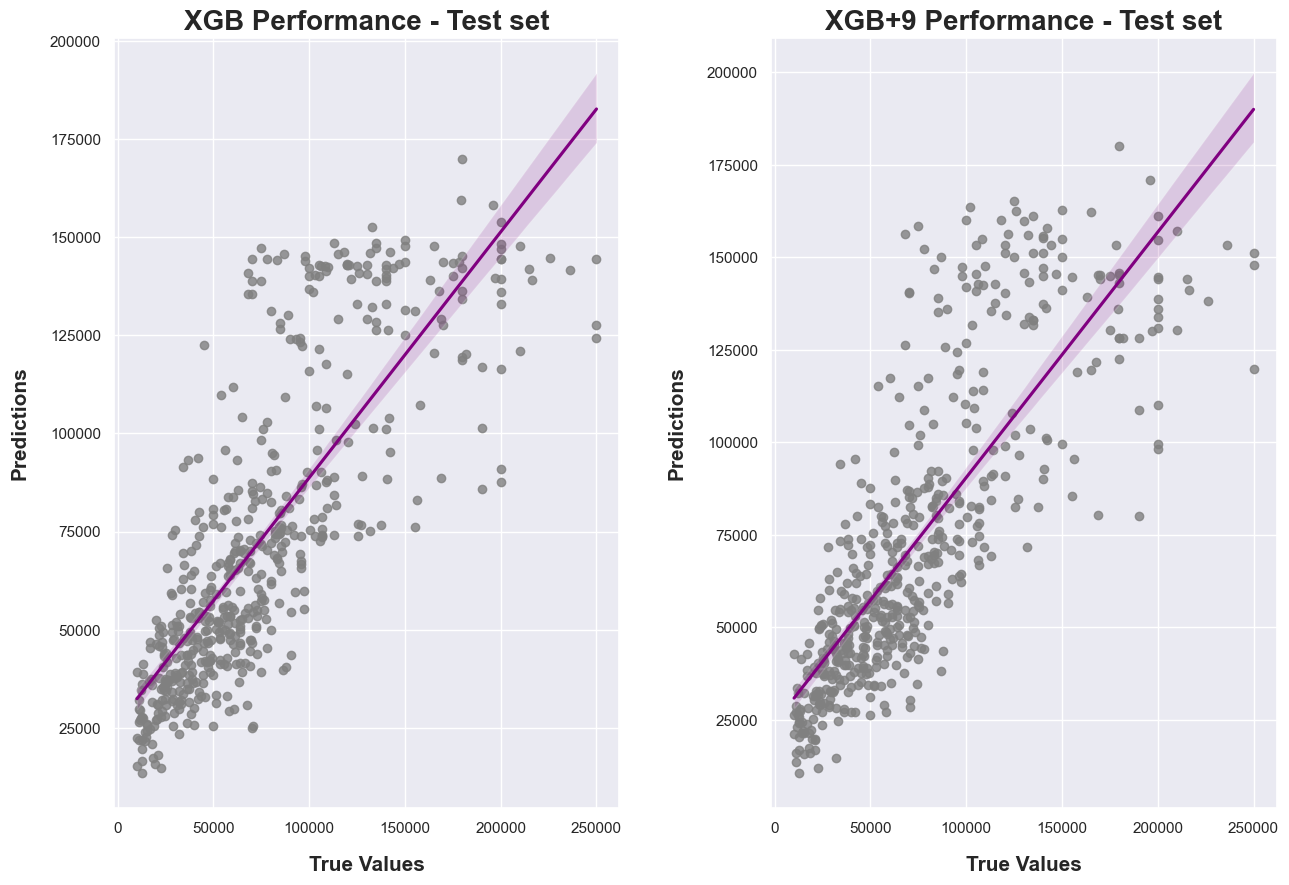

In [238]:
model_names = ["XGB", "XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3)  # Ajusta el espacio entre las gráficas

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.regplot(x=y_test, y=y_test_pred, ax=axs[i], 
                line_kws={'color':'purple'}, scatter_kws={'color':'grey'})
    
    axs[i].set_title(f'{model} Performance - Test set', weight='bold', fontsize=20)
    axs[i].set_xlabel('True Values', fontsize=15, weight='bold', labelpad=15)
    axs[i].set_ylabel('Predictions', fontsize=15, weight='bold', labelpad=15)
    
plt.savefig("../../paper/models/comparison-test-predictions.pdf")
plt.show()

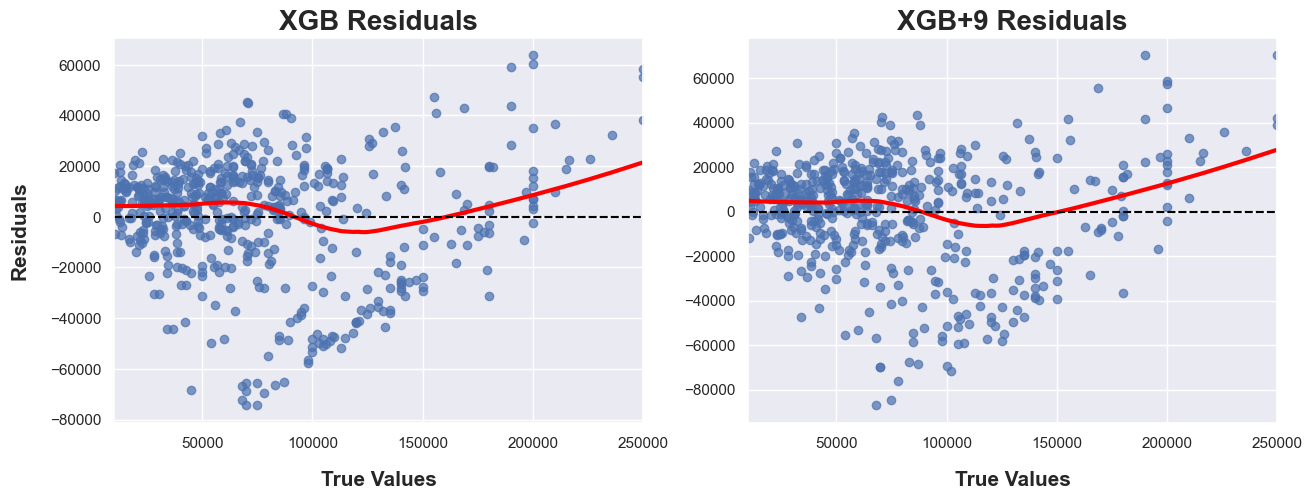

In [239]:
model_names = ["XGB", "XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.2)  

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    residuals = y_test - y_test_pred
    
    sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 3}, ax=axs[i], scatter_kws={'alpha': 0.7})
    axs[i].axhline(y=0, color='black', linestyle='--')
    axs[i].set_title(f'{model} Residuals', weight='bold', fontsize=20)
    axs[i].set_xlabel('True Values', fontsize=15, weight='bold', labelpad=15)
    
    if i == 0:
        axs[i].set_ylabel('Residuals', fontsize=15, weight='bold', labelpad=15)
    else:
        axs[i].set_ylabel('')  
    
plt.savefig("../../paper/models/comparison-residuals.pdf")
plt.show()

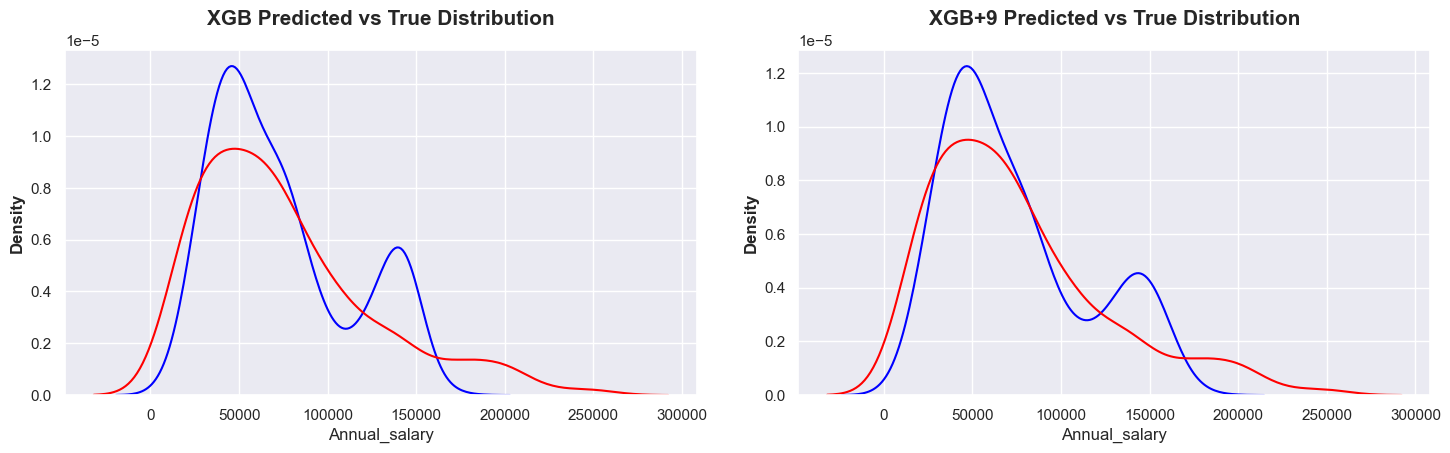

In [240]:
model_names = ["XGB","XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test_pred, color='blue', label='Predicted Values', ax=axs[i])
    sns.kdeplot(x=y_test, color='red', label='True Values', ax=axs[i])
    axs[i].set_title(f'{model} Predicted vs True Distribution', weight='bold', fontsize=15, pad=18)
    
    axs[i].set_ylabel('Density', weight='bold', fontsize=12)

plt.tight_layout(pad=2.0)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

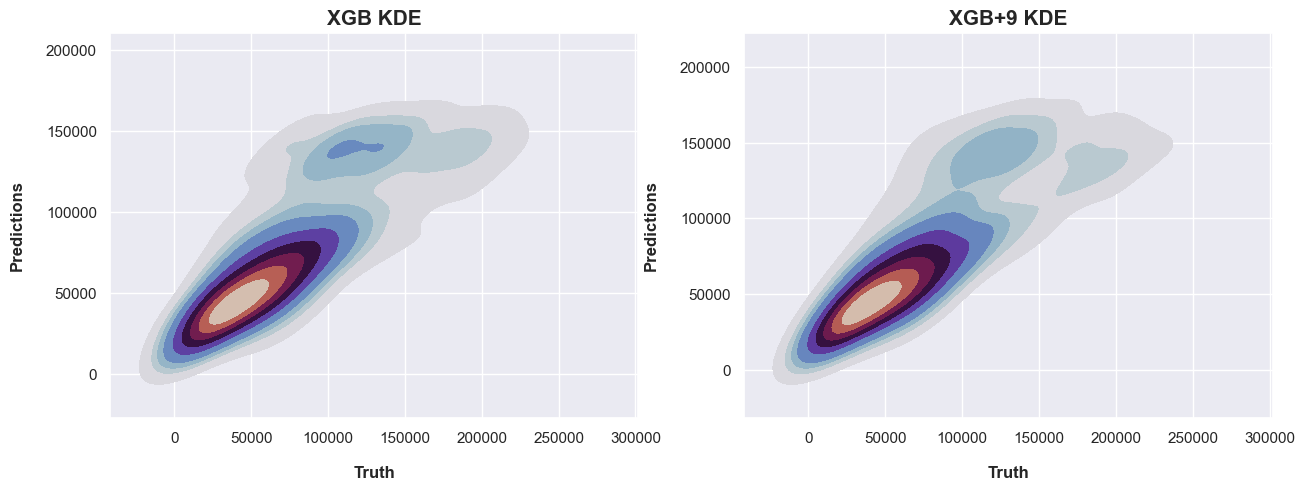

In [241]:
model_names = ["XGB","XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test, y=y_test_pred, fill=True, ax=axs[i], cmap="twilight")
    
    axs[i].set_title(f'{model} KDE', weight='bold', fontsize=15)
    axs[i].set_xlabel('Truth', weight='bold', fontsize=12, labelpad=15)
    axs[i].set_ylabel('Predictions', weight='bold', fontsize=12, labelpad=15)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

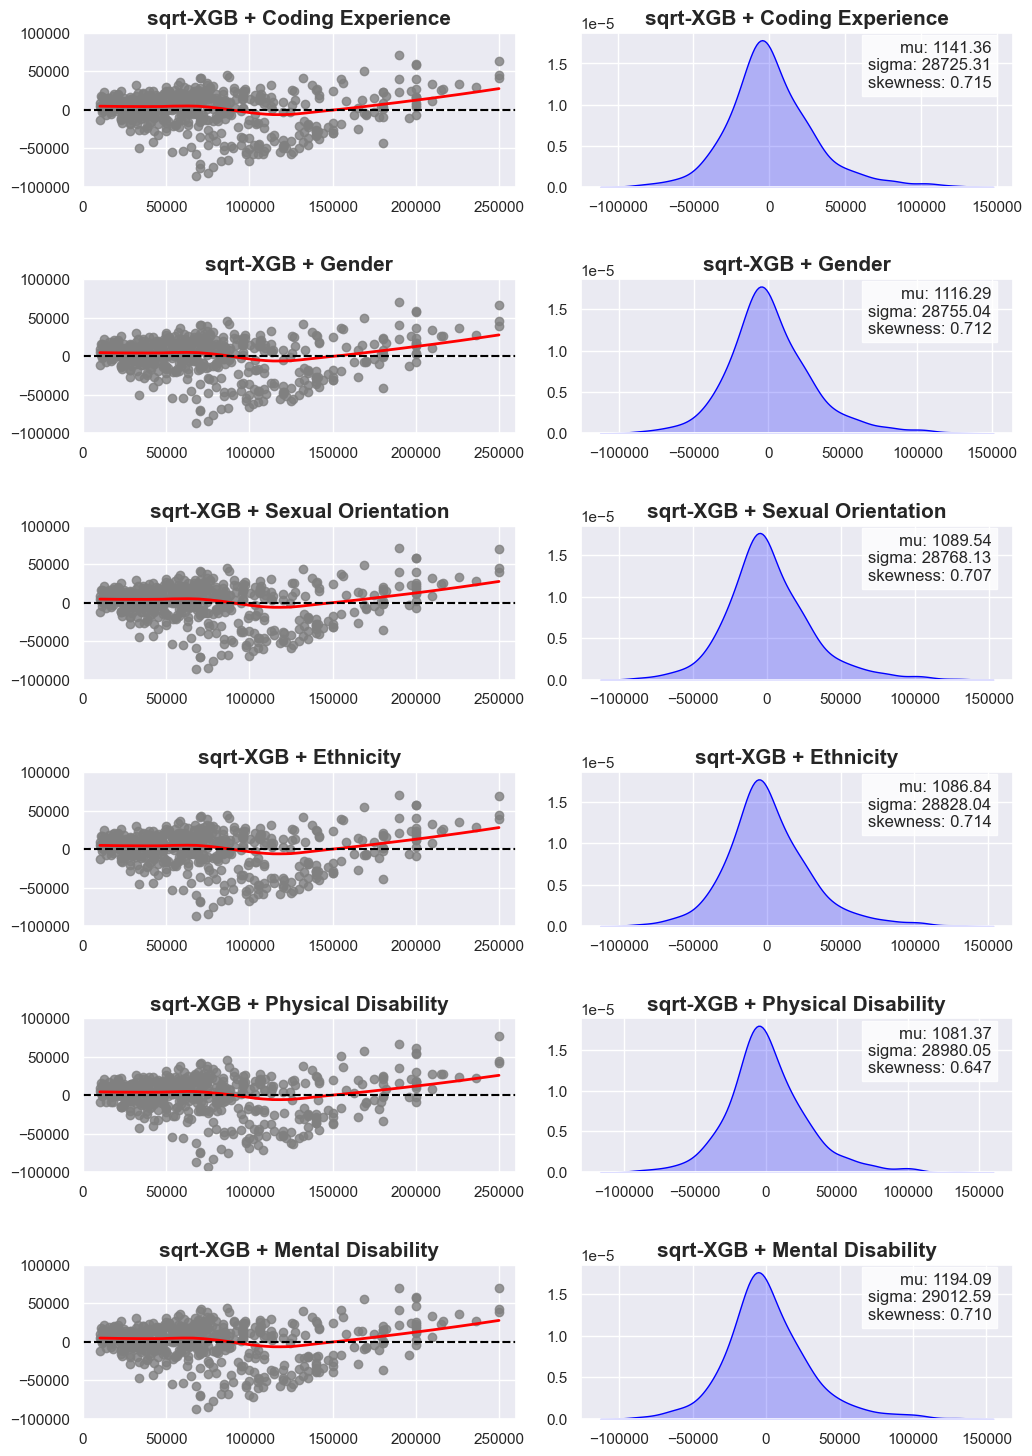

In [242]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_names = [
    "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6",
    "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"
]

new_titles = [
    "sqrt-XGB + Coding Experience", "sqrt-XGB + Gender", "sqrt-XGB + Sexual Orientation", "sqrt-XGB + Ethnicity",
    "sqrt-XGB + Physical Disability", "sqrt-XGB + Mental Disability"
]

fig, axs = plt.subplots(6, 2, figsize=(12, 18))  # Create subplots in 6 rows and 2 columns
plt.subplots_adjust(hspace=0.6, wspace=0.15)  # Adjust vertical and horizontal spacing

for i, (model, title) in enumerate(zip(model_names, new_titles)):
    # Load test predictions and calculate residuals
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")
    residuals = y_test - y_test_pred
    
    # Create residual plots
    sns.residplot(
        x=y_test, y=residuals, lowess=True,
        line_kws={'color': 'red', 'lw': 2}, ax=axs[i, 0], scatter_kws={'color': 'gray','alpha': 0.8}
    )
    
    axs[i, 0].axhline(y=0, color='black', linestyle='--')
    axs[i, 0].set_title(f'{title}', weight='bold', fontsize=15)
    axs[i, 0].set_ylabel('')
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_xlim(0, 260000)
    axs[i, 0].set_ylim(-100000, 100000)

    # Create density plots
    sns.kdeplot(residuals, ax=axs[i, 1], color='blue', fill=True)
    axs[i, 1].set_title(f'{title}', weight='bold', fontsize=15)
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_ylabel('')
    
    # Calculate mu and sigma
    mu = np.mean(residuals)
    sigma = np.std(residuals)
    skewness = stats.skew(residuals)
    
    # Add mu, sigma, and skewness values as text in the plot
    axs[i, 1].text(0.95, 0.95, f'mu: {mu:.2f}\nsigma: {sigma:.2f}\nskewness: {skewness:.3f}',
                   ha='right', va='top', transform=axs[i, 1].transAxes,
                   bbox=dict(facecolor='white', alpha=0.8))

# Save the figure and display it
plt.savefig("../../paper/models/comparison-residuals-density.pdf")
plt.show()


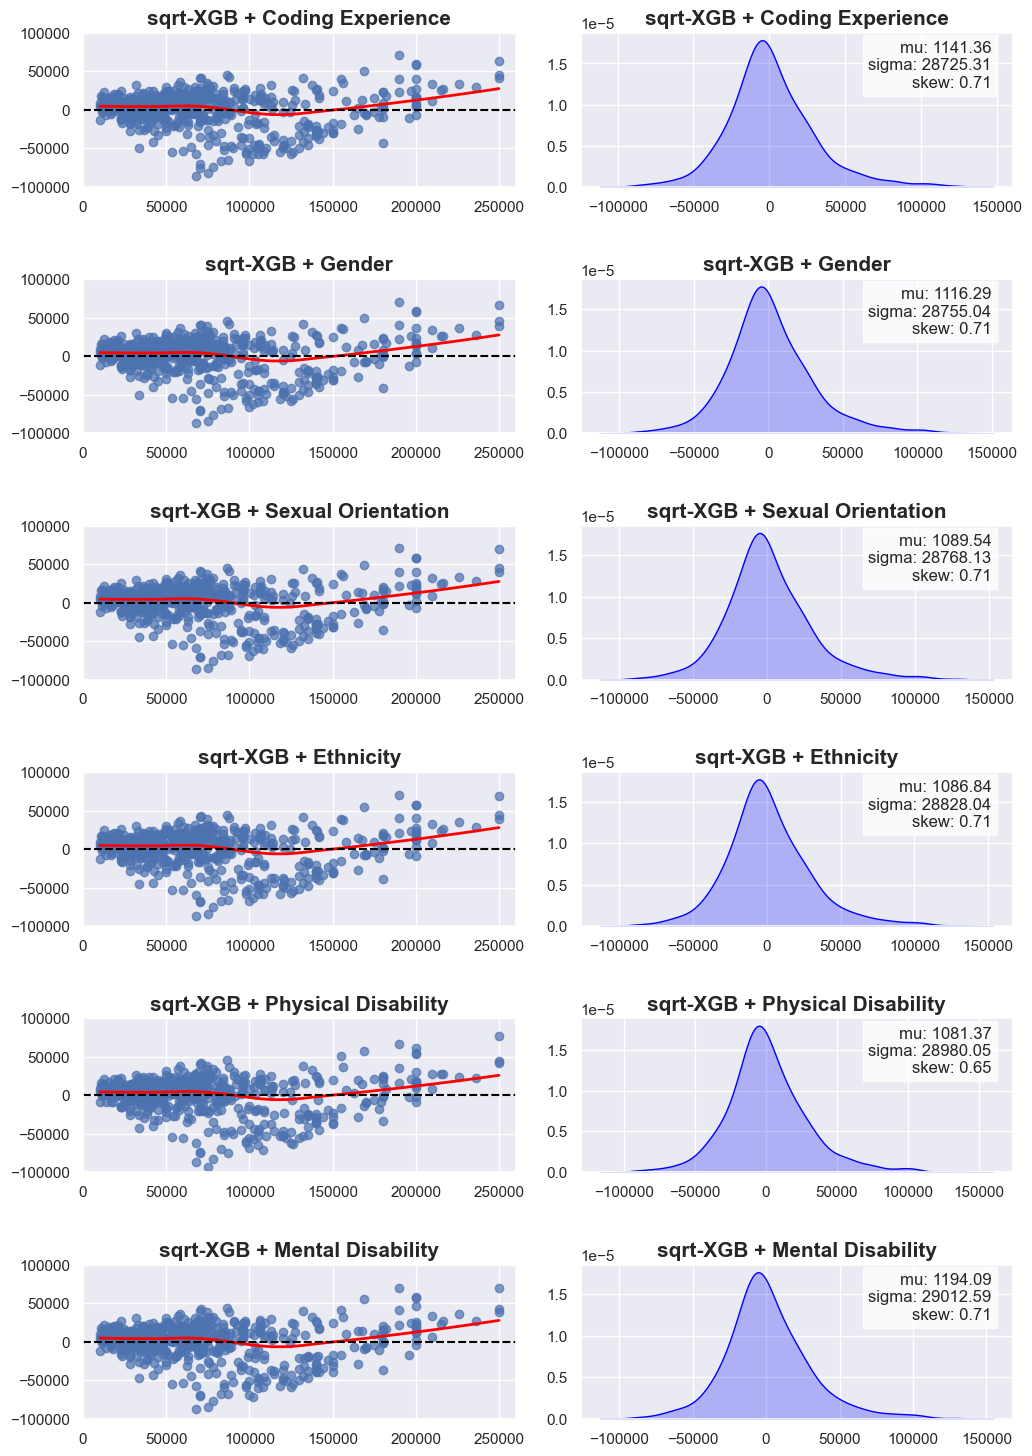

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Your model_names, new_titles, and y_test definitions go here...

fig, axs = plt.subplots(6, 2, figsize=(12, 18))  # Create subplots in 6 rows and 2 columns
plt.subplots_adjust(hspace=0.6, wspace=0.15)  # Adjust vertical and horizontal spacing

for i, (model, title) in enumerate(zip(model_names, new_titles)):
    # Load test predictions and calculate residuals
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")
    residuals = y_test - y_test_pred
    
    # Create residual plots
    sns.residplot(
        x=y_test, y=residuals, lowess=True,
        line_kws={'color': 'red', 'lw': 2}, ax=axs[i, 0], scatter_kws={'alpha': 0.7}
    )
    
    axs[i, 0].axhline(y=0, color='black', linestyle='--')
    axs[i, 0].set_title(f'{title}', weight='bold', fontsize=15)
    axs[i, 0].set_ylabel('')
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_xlim(0, 260000)
    axs[i, 0].set_ylim(-100000, 100000)

    # Create density plots
    sns.kdeplot(residuals, ax=axs[i, 1], color='blue', fill=True)
    axs[i, 1].set_title(f'{title}', weight='bold', fontsize=15)
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_ylabel('')
    
    # Calculate mu, sigma, and skewness
    mu = np.mean(residuals)
    sigma = np.std(residuals)
    skewness = stats.skew(residuals)
    
    # Add mu, sigma, and skewness values as text in the plot
    axs[i, 1].text(0.95, 0.95, f'mu: {mu:.2f}\nsigma: {sigma:.2f}\nskew: {skewness:.2f}',
                   ha='right', va='top', transform=axs[i, 1].transAxes,
                   bbox=dict(facecolor='white', alpha=0.8))

# Save the figure and display it
plt.savefig("../../paper/models/comparison-residuals-density.pdf")
plt.show()


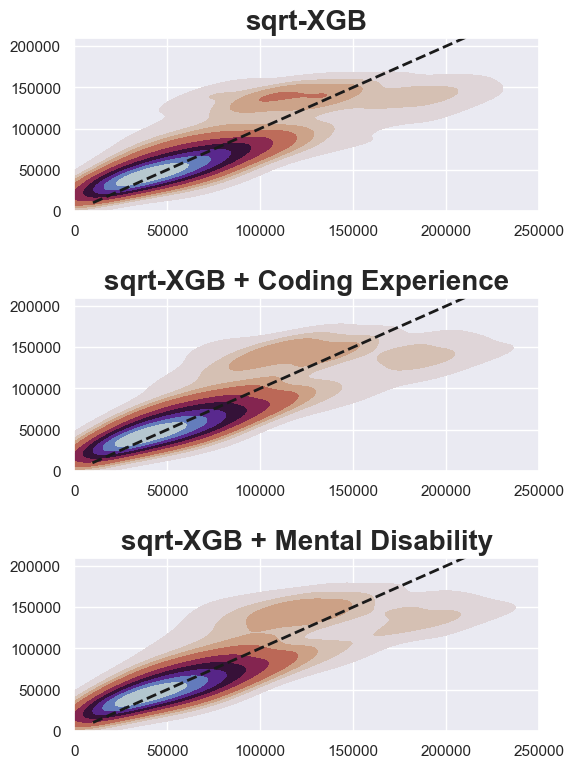

In [244]:
model_names = ["sqrt-XGB", "sqrt-XGB+4", "sqrt-XGB+9"]
new_titles = [
    "sqrt-XGB", "sqrt-XGB + Coding Experience", "sqrt-XGB + Mental Disability"
]
fig, axs = plt.subplots(3, 1, figsize=(6, 9))  # Adjusted figure size for better visibility
plt.subplots_adjust(hspace=0.5)
for i, (model, title) in enumerate(zip(model_names, new_titles)):
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")
    # Plot KDE
    sns.kdeplot(x=y_test, y=y_test_pred, fill=True, ax=axs[i], cmap="twilight_r") #PuOr_r
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    axs[i].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)
    axs[i].set_title(f'{title}', weight='bold', fontsize=20)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xlim(0,250000)
    axs[i].set_ylim(0,210000)
    # axs[i].set_ylabel('')
# plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

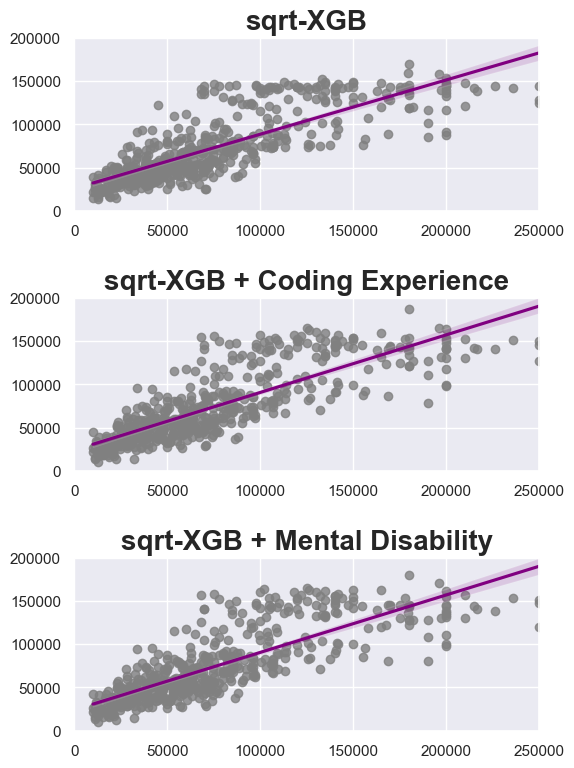

In [245]:
model_names = ["sqrt-XGB", "sqrt-XGB+4", "sqrt-XGB+9"]
new_titles = [
    "sqrt-XGB", "sqrt-XGB + Coding Experience", "sqrt-XGB + Mental Disability"
]
fig, axs = plt.subplots(3, 1, figsize=(6, 9))  # Adjusted figure size for better visibility
plt.subplots_adjust(hspace=0.5)
for i, (model, title) in enumerate(zip(model_names, new_titles)):
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")
    sns.regplot(x=y_test, y=y_test_pred, ax=axs[i],
                line_kws={'color':'purple'}, scatter_kws={'color':'grey'})
    axs[i].set_title(f'{title}', weight='bold', fontsize=20)
    axs[i].set_xlabel('')
    axs[i].set_xlim(0,250000)
    axs[i].set_ylim(0,200000)
    # axs[i].set_ylabel('Predictions', fontsize=15, weight='bold', labelpad=15)
plt.savefig("../../paper/models/comparison-test-predictions.pdf")
plt.show()

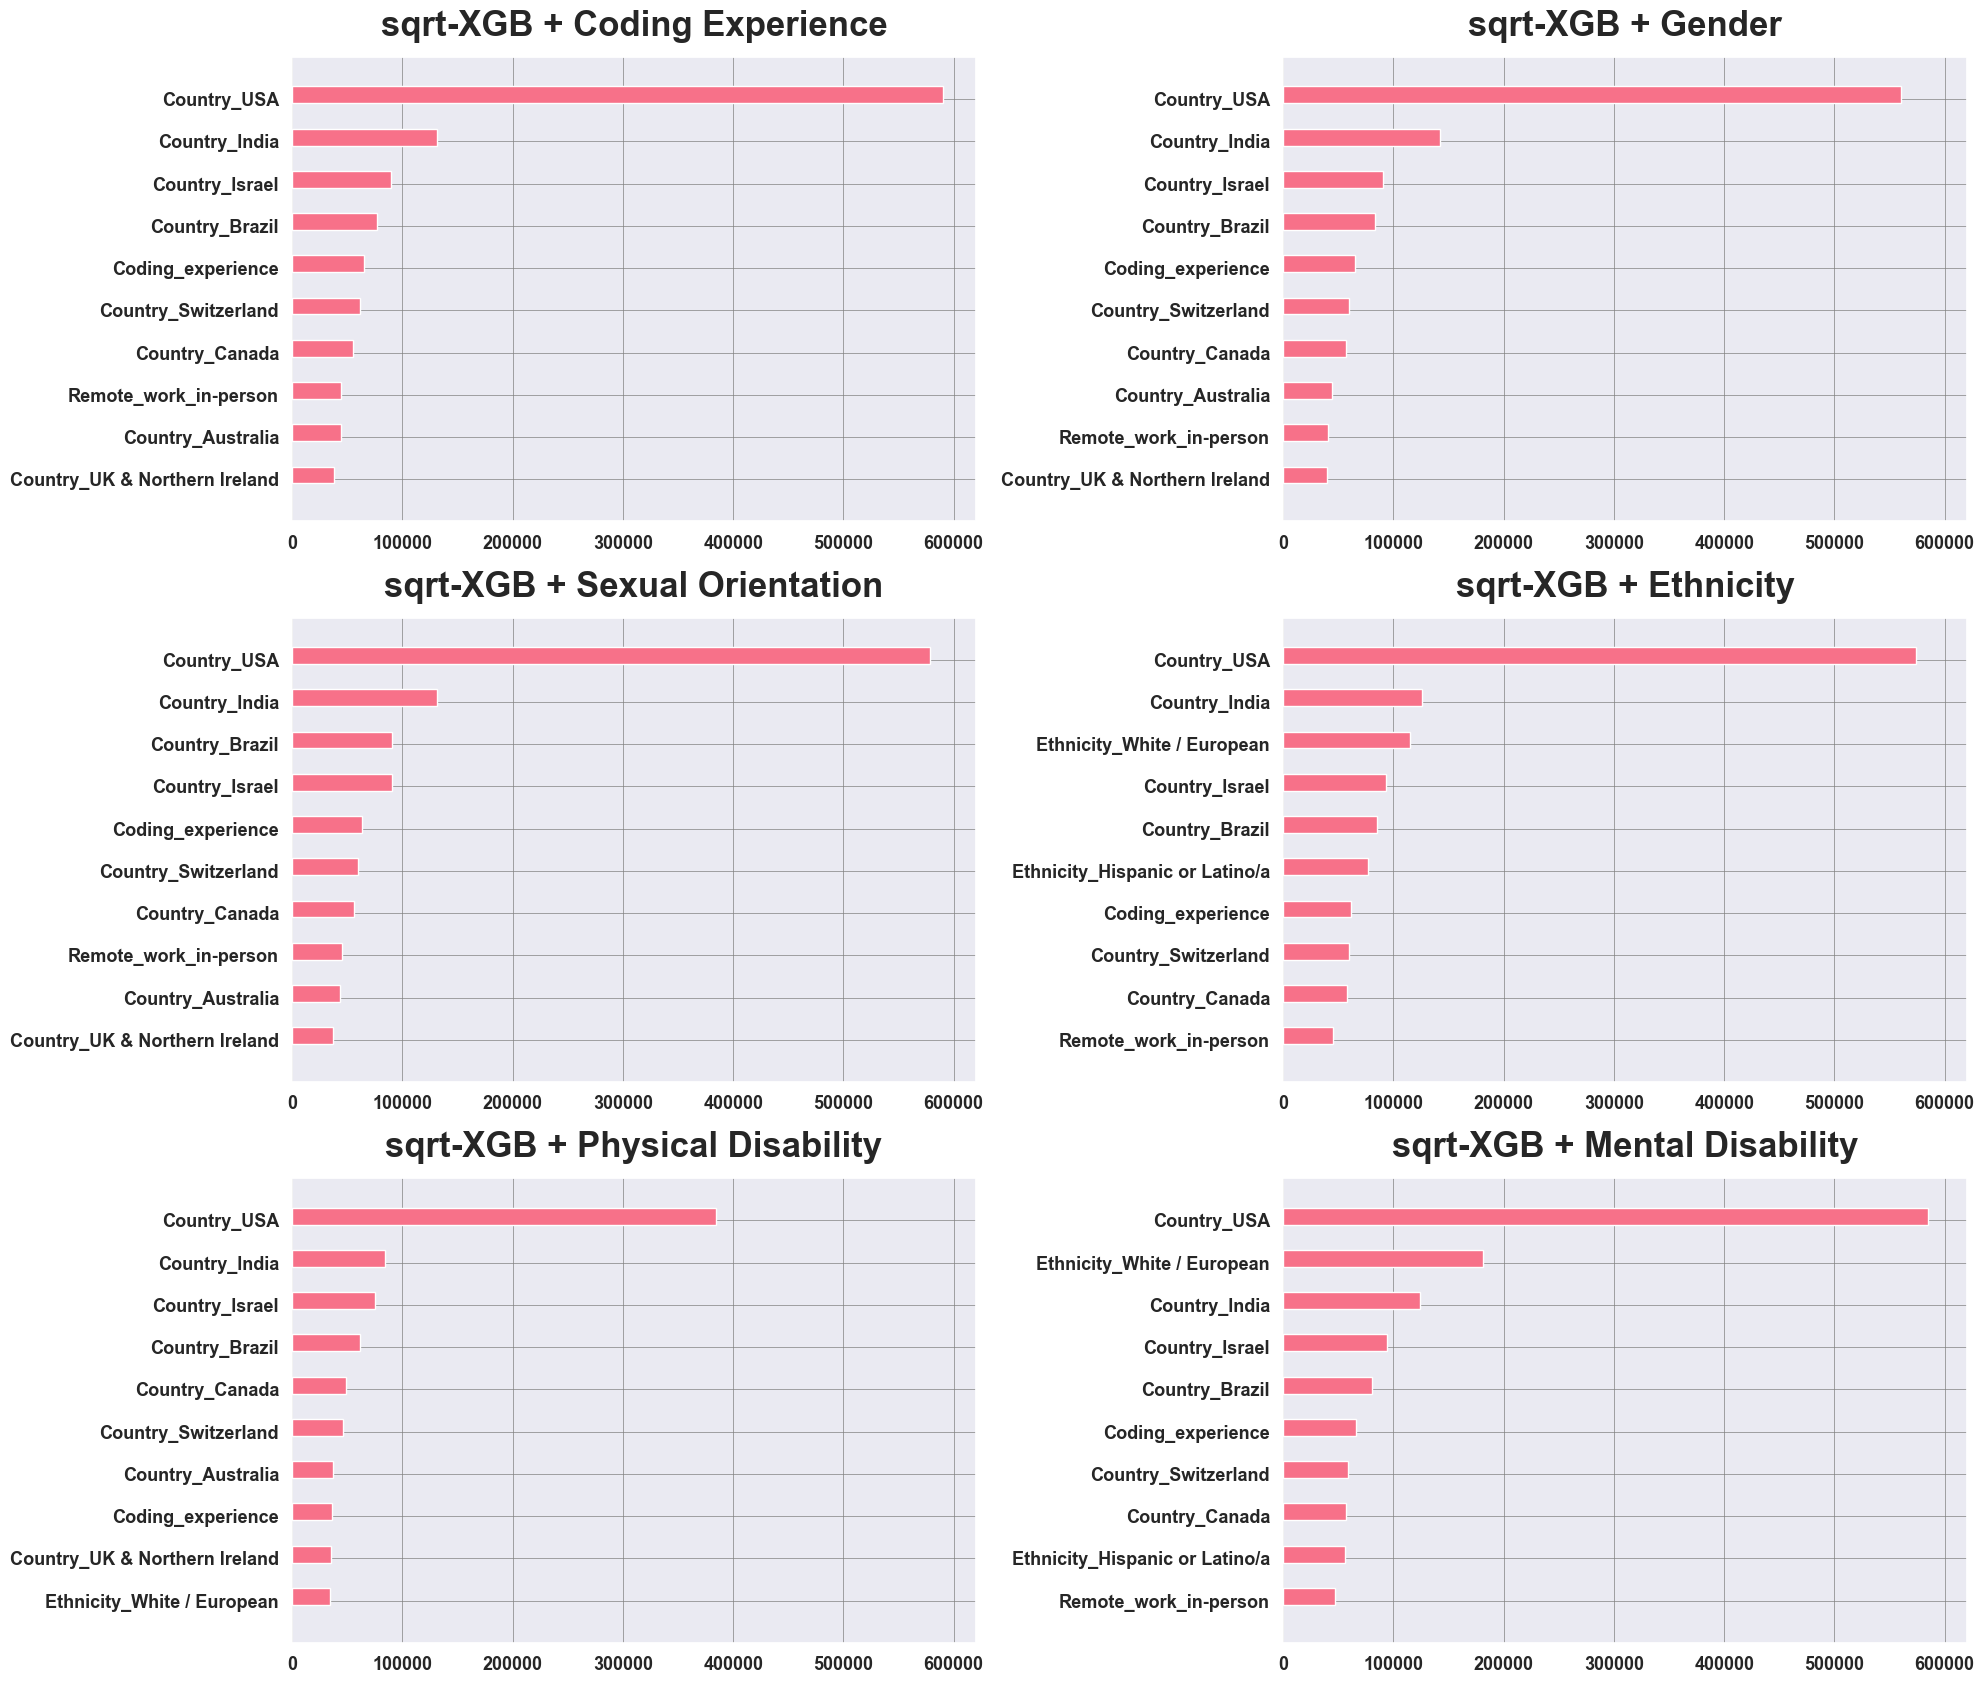

In [246]:
# Load models
models = []
model_filenames = ['model_xgb+4.pkl', 'model_xgb+5.pkl', 'model_xgb+6.pkl', 'model_xgb+7.pkl', 'model_xgb+8.pkl', 'model_xgb+9.pkl']
for filename in model_filenames:
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        models.append(model)

# Define custom titles
new_titles = [
    "sqrt-XGB + Coding Experience", "sqrt-XGB + Gender", "sqrt-XGB + Sexual Orientation",
    "sqrt-XGB + Ethnicity", "sqrt-XGB + Physical Disability", "sqrt-XGB + Mental Disability"
]

# Set the theme for seaborn
sns.set_theme(style='darkgrid', palette='husl')

# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(20, 17))
axs_flat = axs.flatten()

# Plot feature importance for each model with custom titles
for i, model in enumerate(models):
    xgb.plot_importance(model, importance_type='gain', max_num_features=10, ax=axs_flat[i], show_values=False)
    axs_flat[i].set_title(new_titles[i], fontsize=25, pad=15, weight='bold')
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')

    # Customizing bars
    for bar in axs_flat[i].patches:
        bar.set_height(bar.get_height() * 2)

    # Customizing labels
    y_labels = axs_flat[i].get_yticklabels()
    x_labels = axs_flat[i].get_xticklabels()
    for label in y_labels:
        label.set_weight('bold')
        label.set_fontsize(13)
    for label in x_labels:
        label.set_weight('bold')
        label.set_fontsize(13)

    axs_flat[i].set_xlim(0, 620000)
    axs_flat[i].grid(which='both', linestyle='-', linewidth=0.5, color='gray')

# Adjust layout
plt.tight_layout()
plt.savefig("../../paper/models/all-models-feature-importance.pdf")
plt.show()
